### Llibreries

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import scikitplot as skplt

from sklearn.model_selection import train_test_split

## Lip Reading - Word Recognition entrenat amb 'Conv3D layer'

### Creació del dataset

In [5]:
carpeta_principal = 'lipread_mp4_demo/'
word_path = []
ttv_path = []

for entrada in os.listdir(carpeta_principal):
    ruta_absoluta = os.path.join(carpeta_principal, entrada)
    # Verifica si la entrada es una carpeta
    if os.path.isdir(ruta_absoluta):
        # Ruta de la carpeta que contiene las imágenes
        carpeta_1 = carpeta_principal + entrada
        # Itera sobre todos los archivos en la carpeta
        for subcarpeta in os.listdir(carpeta_1):
            # Itera sobre todas las carpetas test, train y val
            carpeta_2 = carpeta_1+'/'+subcarpeta
            # Obtener la lista de elementos (archivos y carpetas) en la carpeta
            elementos = os.listdir(carpeta_2)
            # Contar el número de elementos en la lista
            num_elementos = len(elementos)
            ttv_path.append(int(num_elementos/2))

        word_path.append(ttv_path)
        ttv_path = []

word_path

[[50, 1000, 50],
 [50, 853, 50],
 [50, 1000, 50],
 [50, 1000, 50],
 [50, 1000, 50],
 [50, 1000, 50],
 [50, 1000, 50],
 [50, 954, 50],
 [50, 834, 50],
 [50, 1000, 50]]

In [7]:
carpeta_principal = 'img_mouth_lipread_resize_demo_2/'

ttv_cont = 0
ttv_value = []
for files in word_path:
    for file_lenght in files:
        for i in range(file_lenght):
            ttv_value.append(ttv_cont)
        ttv_cont = ttv_cont + 1
    ttv_cont = 0

In [8]:
len(ttv_value)

10641

In [9]:
carpeta_principal = 'img_mouth_lipread_resize_demo_2/'

test = []
train = []
value = []
clip = []
i = 0

for entrada in os.listdir(carpeta_principal):
    ruta_absoluta = os.path.join(carpeta_principal, entrada)
    image= cv2.imread(ruta_absoluta)
    clip.append(image)
    
    if(len(clip) == 10):
        if (ttv_value[i] == 0):
            test.append(clip)
        else:
            if (ttv_value[i] == 1):
                train.append(clip)
            else:
                if (ttv_value[i] == 2):
                    value.append(clip)
        i = i + 1
        clip = []
    

KeyboardInterrupt: 

In [ ]:
print(len(test), len(train), len(value))

In [ ]:
plt.imshow(cv2.cvtColor(test[0][9], cv2.COLOR_BGR2RGB))

In [ ]:
test_np = np.array(test)
train_np = np.array(train)
value_np = np.array(value)
print("test_np shape: ", test_np.shape)
print("train_np shape: ", train_np.shape)
print("value_np shape: ", value_np.shape)

In [ ]:
dataset_np = np.concatenate((train_np, test_np), axis=0)
print("dataset_np shape: ", dataset_np.shape)

In [ ]:
y_test = []
y_train = []
y_value = []
word_count = 0
for files in word_path:
    for i in range(files[0]):
        y_test.append(word_count)
    for i in range(files[1]):
        y_train.append(word_count)
    for i in range(files[2]):
        y_value.append(word_count)
    word_count = word_count + 1

In [ ]:
print(len(y_test), len(y_train), len(y_value))

In [ ]:
y_test_np = np.array(y_test)
y_train_np = np.array(y_train)
y_value_np = np.array(y_value)
print("test_np shape: ", y_test_np.shape)
print("train_np shape: ", y_train_np.shape)
print("value_np shape: ", y_value_np.shape)

In [ ]:
y_dataset_np = np.concatenate((y_train_np, y_test_np), axis=0)
print("dataset_np shape: ", y_dataset_np.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset_np, y_dataset_np, test_size=0.2, random_state=42)

In [ ]:
class CFG:
    epochs = 10
    batch_size = 32
    classes = ["ATTACK", "BLACK", "FINAL", "IMPACT", "LATER", "MEDIA", "OFFICE", "PRESS", "SPEND", "WEEKS"]

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
valid = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

### Creació del model amb 'Conv3D layer'

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10, 50, 100, 3)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(CFG.classes), activation="softmax")
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[
        "accuracy"
    ]
)
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/model_PreMouth_Resize_2.keras", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
history = model.fit(
    train,
    epochs=30, 
    validation_data=valid, 
    callbacks=[checkpoint]
)

Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 149s 580ms/step - accuracy: 0.1180 - loss: 6.5127 - val_accuracy: 0.2247 - val_loss: 2.0339
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 148s 582ms/step - accuracy: 0.3151 - loss: 1.8744 - val_accuracy: 0.3627 - val_loss: 1.8332
Epoch 3/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 149s 586ms/step - accuracy: 0.4468 - loss: 1.6129 - val_accuracy: 0.4628 - val_loss: 1.5835
Epoch 4/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 157s 619ms/step - accuracy: 0.5220 - loss: 1.4231 - val_accuracy: 0.5451 - val_loss: 1.3278
Epoch 5/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 171s 674ms/step - accuracy: 0.5744 - loss: 1.2850 - val_accuracy: 0.5599 - val_loss: 1.2910
Epoch 6/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 161s 635ms/step - accuracy: 0.6035 - loss: 1.2027 - val_accuracy: 0.5806 - val_loss: 1.2496
Epoch 7/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 172s 676ms/step - accuracy: 0.6348 - loss: 1.1164 - val_accuracy: 0.5988 - val_loss: 1.2457
Epoch 8/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 171s 674ms/step - accuracy: 0.6516 -

FileNotFoundError: [Errno 2] No such file or directory: 'model.keras'

In [22]:
model.load_weights("model_PreMouth_Resize_2.keras")

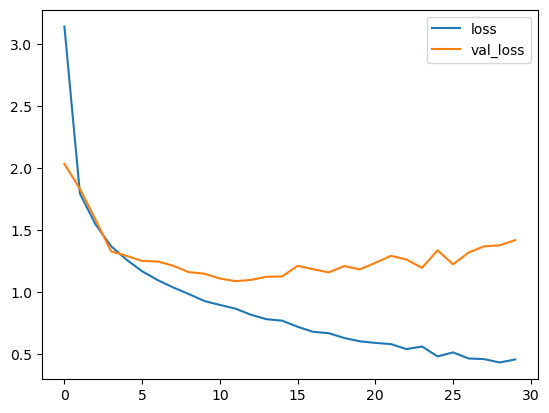

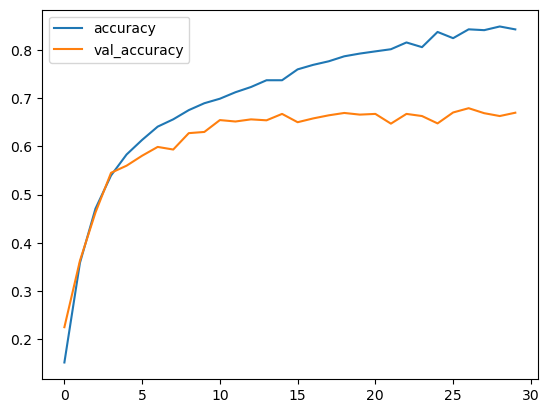

In [23]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [24]:
# Guardar el modelo
model.save('models/LRW_Conv3D_resize_2.keras')

### Cargar el model entrenat previament

In [11]:
# Cargar el modelo desde el formato SavedModel
model = tf.keras.models.load_model('models/LRW_Conv3D_resize_2.keras')

# Mostrar el resumen del modelo para verificar que se ha cargado correctamente
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 10, 50, 100, 32)     │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 5, 25, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 5, 25, 50, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 2, 12, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 2, 12, 25, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 1, 6, 12, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 6, 12, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,760 (3.21 MB)

 Trainable params: 280,586 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 561,174 (2.14 MB)

In [ ]:
# Suponiendo que tienes tu conjunto de datos de prueba X_test y las etiquetas verdaderas y_test
# Obtener las predicciones del modelo
y_pred_prob = model.predict(train_features)
# Convertir las predicciones de probabilidad a etiquetas
y_pred = np.argmax(y_pred_prob, axis=1)

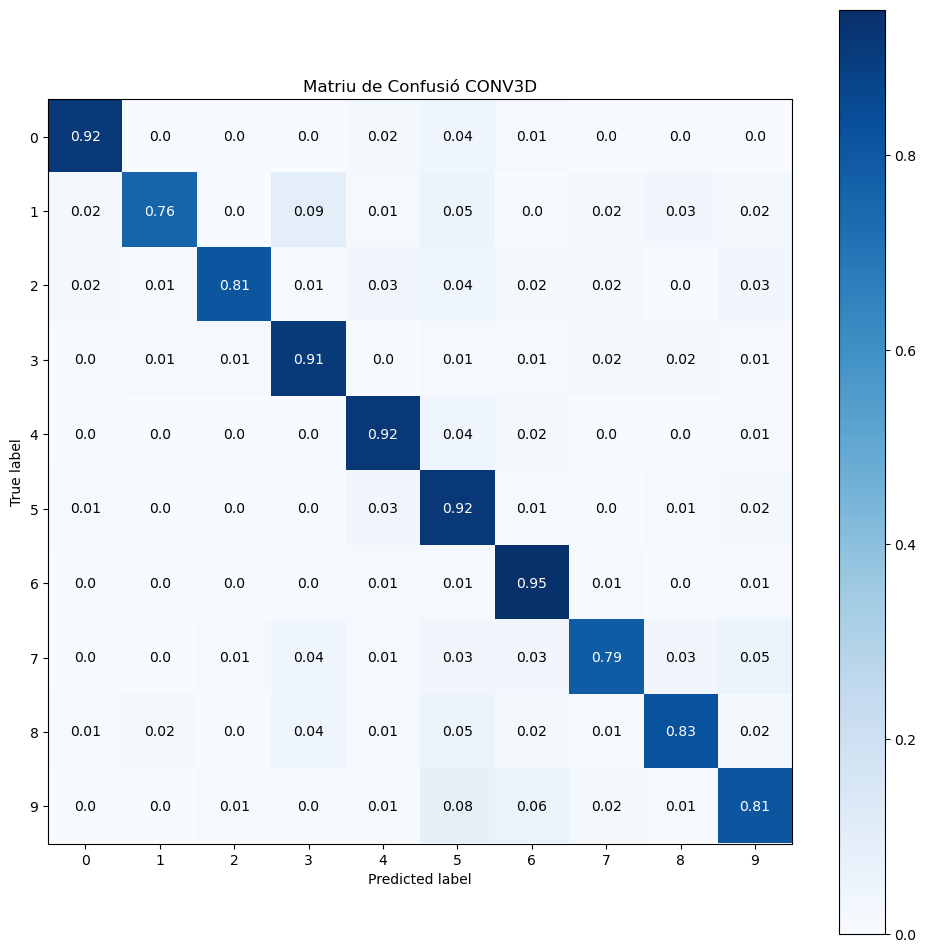

In [18]:
skplt.metrics.plot_confusion_matrix(
    train_targets, 
    y_pred,
    figsize=(12, 12),  
    title='Matriu de Confusió CONV3D',
    cmap='Blues',  
    normalize=True
)

# Mostrar los números de cada casilla
plt.show()